<a href="https://colab.research.google.com/github/DhrubaAdhikary/GEN_AI_DEMO/blob/master/2_stage_Retrieval_RAG_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

.

🧠 RAG ARCHITECTURE (WITH 2-STAGE RETRIEVAL)

                    ┌──────────────┐
                    │  Documents   │
                    └──────┬───────┘
                           │
                    ┌──────▼───────┐
                    │   Chunking   │
                    └──────┬───────┘
                           │
                    ┌──────▼───────┐
                    │  Embeddings  │  ← Sentence Transformer
                    └──────┬───────┘
                           │
                    ┌──────▼───────┐
                    │ Vector Store │  ← Chroma (ANN / FAISS-style)
                    └──────┬───────┘
                           │
         Stage 1 Retrieval │  (Recall-oriented)
                           ▼
                 ┌───────────────────┐
                 │  Top-K Candidates │  (k=20)
                 └─────────┬─────────┘
                           │
         Stage 2 Retrieval │  (Precision-oriented)
                           ▼
                 ┌───────────────────┐
                 │   Reranker Model  │  ← Cross-Encoder
                 └─────────┬─────────┘
                           │
                           ▼
                 ┌───────────────────┐
                 │  Top-N Context    │  (n=4)
                 └─────────┬─────────┘
                           │
                           ▼
                 ┌───────────────────┐
                 │       LLM         │
                 └─────────┬─────────┘
                           ▼
                      Final Answer


In [1]:
# Install Dependencies
!pip install \
  langchain==0.1.20 \
  langchain-community==0.0.38 \
  langchain-openai==0.1.7 \
  sentence-transformers==2.6.1 \
  chromadb==0.4.24 \
  faiss-cpu==1.13.2 \
  pypdf==4.2.0 \
  scikit-learn==1.4.0 \
  umap-learn==0.5.5 \
  matplotlib==3.8.2

In [2]:
#upload FIle in Colab native env
from google.colab import files

uploaded = files.upload()


Saving CV #5 Canny_Hough (1).pdf to CV #5 Canny_Hough (1).pdf


In [3]:
from langchain_community.document_loaders import PyPDFLoader, TextLoader
from pathlib import Path

filename = list(uploaded.keys())[0]
suffix = Path(filename).suffix.lower()

if suffix == ".pdf":
    loader = PyPDFLoader(filename)
else:
    loader = TextLoader(filename)

documents = loader.load()
print(f"Loaded {len(documents)} pages")


/usr/local/lib/python3.12/dist-packages/pypdf/_crypt_providers/_cryptography.py:32: CryptographyDeprecationWarning: ARC4 has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.ARC4 and will be removed from this module in 48.0.0.
  from cryptography.hazmat.primitives.ciphers.algorithms import AES, ARC4


Loaded 40 pages


In [4]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(
    chunk_size=800,
    chunk_overlap=150
)

chunks = splitter.split_documents(documents)
print(f"Created {len(chunks)} chunks")


Created 40 chunks


In [5]:
from langchain_community.embeddings import HuggingFaceEmbeddings

embedding_model = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    encode_kwargs={"normalize_embeddings": True}
)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [6]:
from langchain_community.vectorstores import Chroma

vectorstore = Chroma.from_documents(
    documents=chunks,
    embedding=embedding_model,
    persist_directory="chroma_db"
)

vectorstore.persist()


ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
/usr/local/lib/python3.12/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  warn_deprecated(


In [7]:
retriever_stage1 = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 20}   # High recall
)


In [8]:
from sentence_transformers import CrossEncoder

reranker = CrossEncoder(
    "cross-encoder/ms-marco-MiniLM-L-6-v2"
)


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

In [9]:
def retrieve_with_rerank(query, top_k_stage1=20, top_k_final=4):
    # Stage 1
    docs = retriever_stage1.get_relevant_documents(query)

    # Prepare reranker inputs
    pairs = [[query, doc.page_content] for doc in docs]
    scores = reranker.predict(pairs)

    # Sort by reranker score
    ranked_docs = sorted(
        zip(docs, scores),
        key=lambda x: x[1],
        reverse=True
    )

    return [doc for doc, _ in ranked_docs[:top_k_final]]


In [12]:
from google.colab import userdata
import os

# Fetch from Colab Secrets
api_key = userdata.get("OPENAI_API_KEY")

if not api_key:
    raise ValueError(
        "OPENAI_API_KEY not found in Colab Secrets. "
        "Add it via the 🔒 Secrets panel."
    )

os.environ["OPENAI_API_KEY"] = api_key

print("OPENAI_API_KEY loaded successfully")


OPENAI_API_KEY loaded successfully


In [13]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-3.5-turbo",
    temperature=0
)


In [14]:
from langchain.schema import HumanMessage

def rag_answer(query):
    context_docs = retrieve_with_rerank(query)

    context = "\n\n".join(
        f"[{i+1}] {doc.page_content}"
        for i, doc in enumerate(context_docs)
    )

    prompt = f"""
Use the following context to answer the question.
If the answer is not present, say so explicitly.

Context:
{context}

Question:
{query}
"""

    response = llm([HumanMessage(content=prompt)])
    return response.content, context_docs


In [15]:
query = "Summarize the key findings of the document."

answer, sources = rag_answer(query)

print("ANSWER:\n")
print(answer)


/usr/local/lib/python3.12/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given
/usr/local/lib/python3.12/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


ANSWER:

The document discusses the Hough Transform technique for line fitting, which is used to determine the lines present in a set of points, how many lines there are, and which points belong to which lines. The main idea is to record votes for each possible line based on where edge points lie, and then look for lines that receive many votes. Additionally, the document briefly mentions a comparison of color models CMYK, RGB, and HSI, and explains the concepts of brightness, hue, and saturation in color representation.


In [16]:
import numpy as np

texts = [doc.page_content for doc in chunks]
embeddings = embedding_model.embed_documents(texts)

X = np.array(embeddings)


In [17]:
import umap

reducer = umap.UMAP(
    n_components=3,
    random_state=42,
    metric="cosine"
)

X_3d = reducer.fit_transform(X)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


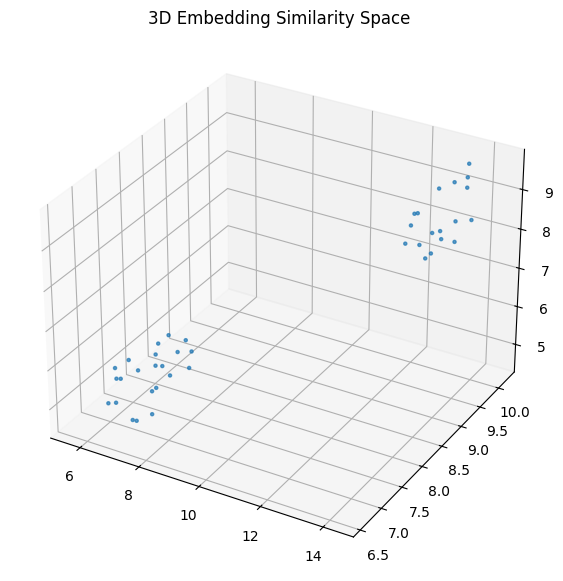

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    X_3d[:, 0],
    X_3d[:, 1],
    X_3d[:, 2],
    s=5,
    alpha=0.7
)

ax.set_title("3D Embedding Similarity Space")
plt.show()


In [19]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

TOP_K = 5
sim = cosine_similarity(X)

neighbors = {
    i: np.argsort(sim[i])[::-1][1:TOP_K+1]
    for i in range(len(X))
}


In [25]:
import numpy as np

X = np.array(embeddings)


In [26]:
import umap

reducer = umap.UMAP(
    n_components=3,
    random_state=42,
    metric="cosine"
)

X_3d = reducer.fit_transform(X)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [27]:
from sklearn.metrics.pairwise import cosine_similarity

TOP_K = 5

similarity_matrix = cosine_similarity(X)

neighbors = {
    i: np.argsort(similarity_matrix[i])[::-1][1:TOP_K+1]
    for i in range(len(X))
}


In [28]:
edge_x, edge_y, edge_z = [], [], []

for i, nbrs in neighbors.items():
    for j in nbrs:
        edge_x += [X_3d[i, 0], X_3d[j, 0], None]
        edge_y += [X_3d[i, 1], X_3d[j, 1], None]
        edge_z += [X_3d[i, 2], X_3d[j, 2], None]


In [23]:
from IPython.display import display, Markdown

def show_text(idx):
    display(Markdown(f"### Selected Chunk\n\n{texts[idx]}"))

def update_trace_with_text(trace, points, selector):
    if points.point_inds:
        show_text(points.point_inds[0])
        update_trace(trace, points, selector)

scatter.on_click(update_trace_with_text)


In [29]:
import plotly.graph_objects as go

fig = go.Figure()

# Nodes
fig.add_trace(
    go.Scatter3d(
        x=X_3d[:, 0],
        y=X_3d[:, 1],
        z=X_3d[:, 2],
        mode="markers",
        marker=dict(size=4, color="lightblue", opacity=0.7),
        text=texts,
        hoverinfo="text",
        name="Chunks"
    )
)

# Edges
fig.add_trace(
    go.Scatter3d(
        x=edge_x,
        y=edge_y,
        z=edge_z,
        mode="lines",
        line=dict(width=1),
        opacity=0.4,
        name="Semantic Neighbors"
    )
)

fig.update_layout(
    title="Semantic Embedding Space (Colab)",
    scene=dict(
        xaxis_title="UMAP-1",
        yaxis_title="UMAP-2",
        zaxis_title="UMAP-3"
    )
)

fig.show()
